In [1]:
import gseapy as gp
import pandas as pd
import numpy as np

## Compute Correlation of Phenotypic Probabilities to Signature Scores

In [2]:
# Check what libraries are available
available_libraries = gp.get_library_name()
hallmark_libs = [lib for lib in available_libraries if 'hallmark' in lib.lower() or 'msig' in lib.lower()]
print("\nHallmark-related libraries:")
for lib in hallmark_libs:
    print(f"  - {lib}")


Hallmark-related libraries:
  - MSigDB_Computational
  - MSigDB_Hallmark_2020
  - MSigDB_Oncogenic_Signatures


In [3]:
msigdb_hallmark = gp.get_library('MSigDB_Hallmark_2020')

gene_set_names = list(msigdb_hallmark.keys())
print(f"Total hallmarks available: {(gene_set_names)}")



Total hallmarks available: ['TNF-alpha Signaling via NF-kB', 'Hypoxia', 'Cholesterol Homeostasis', 'Mitotic Spindle', 'Wnt-beta Catenin Signaling', 'TGF-beta Signaling', 'IL-6/JAK/STAT3 Signaling', 'DNA Repair', 'G2-M Checkpoint', 'Apoptosis', 'Notch Signaling', 'Adipogenesis', 'Estrogen Response Early', 'Estrogen Response Late', 'Androgen Response', 'Myogenesis', 'Protein Secretion', 'Interferon Alpha Response', 'Interferon Gamma Response', 'Apical Junction', 'Apical Surface', 'Hedgehog Signaling', 'Complement', 'Unfolded Protein Response', 'PI3K/AKT/mTOR  Signaling', 'mTORC1 Signaling', 'E2F Targets', 'Myc Targets V1', 'Myc Targets V2', 'Epithelial Mesenchymal Transition', 'Inflammatory Response', 'Xenobiotic Metabolism', 'Fatty Acid Metabolism', 'Oxidative Phosphorylation', 'Glycolysis', 'Reactive Oxygen Species Pathway', 'p53 Pathway', 'UV Response Up', 'UV Response Dn', 'Angiogenesis', 'heme Metabolism', 'Coagulation', 'IL-2/STAT5 Signaling', 'Bile Acid Metabolism', 'Pperoxisome',

In [4]:
# Step 2: Check what gene sets are available
msigdb_hallmark = gp.get_library('MSigDB_Hallmark_2020')

print(f"\nNumber of gene sets: {len(msigdb_hallmark)}")
print("\nFirst 10 gene sets:")
gene_set_names = list(msigdb_hallmark.keys())
for name in gene_set_names:
    print(f"  - {name}")

# Step 3: Look for APOPTOSIS-related gene sets
apoptosis_sets = [name for name in gene_set_names if 'EMT' in name.upper()]
print(f"\nApoptosis-related gene sets:")
for name in apoptosis_sets:
    print(f"  - {name}")


Number of gene sets: 50

First 10 gene sets:
  - TNF-alpha Signaling via NF-kB
  - Hypoxia
  - Cholesterol Homeostasis
  - Mitotic Spindle
  - Wnt-beta Catenin Signaling
  - TGF-beta Signaling
  - IL-6/JAK/STAT3 Signaling
  - DNA Repair
  - G2-M Checkpoint
  - Apoptosis
  - Notch Signaling
  - Adipogenesis
  - Estrogen Response Early
  - Estrogen Response Late
  - Androgen Response
  - Myogenesis
  - Protein Secretion
  - Interferon Alpha Response
  - Interferon Gamma Response
  - Apical Junction
  - Apical Surface
  - Hedgehog Signaling
  - Complement
  - Unfolded Protein Response
  - PI3K/AKT/mTOR  Signaling
  - mTORC1 Signaling
  - E2F Targets
  - Myc Targets V1
  - Myc Targets V2
  - Epithelial Mesenchymal Transition
  - Inflammatory Response
  - Xenobiotic Metabolism
  - Fatty Acid Metabolism
  - Oxidative Phosphorylation
  - Glycolysis
  - Reactive Oxygen Species Pathway
  - p53 Pathway
  - UV Response Up
  - UV Response Dn
  - Angiogenesis
  - heme Metabolism
  - Coagulation
  

In [5]:
from scipy.stats import spearmanr

def correlate_boolean_predictions_with_gene_signatures(proba_phenotype, hallmark, phenotype, rna_seq_data, patients_ids):
    # Preprocessing -> get gene expression matrix
    rna_seq_data_filtered = rna_seq_data[rna_seq_data['model_id'].isin(patients_ids)]


    rna_seq_data_filtered = rna_seq_data_filtered[['model_id', 'gene_symbol', 'rsem_tpm']]


    # remove duplicates (compute mean)
    rna_seq_data_deduplicated = rna_seq_data_filtered.groupby(['model_id', 'gene_symbol']).agg({
        'rsem_tpm': 'mean'
    }).reset_index()


    # Reshape the DataFrame: genes as rows (index), samples as columns, expression as values
    gene_expression_matrix = rna_seq_data_deduplicated.pivot(
        index='gene_symbol',     # Genes become row index
        columns='model_id',      # Model IDs become columns
        values='rsem_tpm'        # Expression values fill the matrix
    )



    # extract genes signature for the specific hallmark given
    msigdb_hallmark = gp.get_library('MSigDB_Hallmark_2020')
    hallmark_phenotype = msigdb_hallmark[hallmark]


    # get phenotype values 

    phenotype_score_df = []
    for patient_id in patients_ids:
       
        sample_expr = gene_expression_matrix[patient_id].dropna()
        # Run ssGSEA for this sample
        gene_sets = {hallmark: hallmark_phenotype}

        ss_result = gp.ssgsea(
            data=sample_expr,
            gene_sets=gene_sets,
            outdir=None,  # Don't save files
            no_plot=True,
            processes=1
        )

        phenotype_score = ss_result.res2d.loc[0, 'ES']
        print(f"  ✅ {hallmark} score: {phenotype_score:.3f}")

        phenotype_score_df.append({
            'patient_id': patient_id,
            f'{hallmark}_gene_signature_score': phenotype_score
        })
    
     


    # filtering proba phenotype df

    phenotype_cols = [col for col in proba_phenotype.columns if phenotype in col]  
    proba_phenotype_filtered = proba_phenotype[phenotype_cols]
    
    proba_phenotype_filtered = proba_phenotype_filtered[proba_phenotype_filtered.index.isin(patients_ids)]
    
    proba_phenotype_filtered = proba_phenotype_filtered.reset_index()
    proba_phenotype_filtered = proba_phenotype_filtered.rename(columns={proba_phenotype_filtered.columns[0]: 'patient_id'})

    phenotype_scores_df = pd.DataFrame(phenotype_score_df) 

    # create correlation data (combination of the proba phenotype and score calculated before)
    correlation_data = phenotype_scores_df.merge(proba_phenotype_filtered, on='patient_id', how='inner')
    results_corr_df = pd.DataFrame(index = phenotype_cols, columns = ['correlation_value', 'p_val'])


    for col in phenotype_cols:
        corr, pval = spearmanr(correlation_data[col], correlation_data[f'{hallmark}_gene_signature_score'])
        results_corr_df.loc[col, 'correlation_value'] = corr
        results_corr_df.loc[col, 'p_val'] = pval


    return results_corr_df, correlation_data
    

In [8]:
import pandas as pd 
proba_phenotype = pd.read_csv('analysis/AZD7762/mutations_genes_normalize/CHK1_2_target_block/results/sensitive_resistant_results/patients_phenot_table.csv', index_col=0)
rna_seq_data = pd.read_csv('data/cellmodel_data/rnaseq_merged_20250117/rnaseq_merged_20250117.csv')

In [33]:
patients_ids = ['SIDM00758', 'SIDM00770', 'SIDM00217', 'SIDM00772', 'SIDM01242', 'SIDM00421']
# hallmark = 'G2-M Checkpoint'

hallmark = 'Epithelial Mesenchymal Transition'
phenotype = 'Invasion'


# hallmark = 'Epithelial Mesenchymal Transition'
# phenotype = 'Invasion'
results_corr_df, correlation_data = correlate_boolean_predictions_with_gene_signatures(proba_phenotype, hallmark, phenotype, rna_seq_data, patients_ids)

/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_78789/2892399700.py:40: DeprecationWarning: processes is deprecated; use threads
  ss_result = gp.ssgsea(
/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_78789/2892399700.py:40: DeprecationWarning: processes is deprecated; use threads
  ss_result = gp.ssgsea(
/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_78789/2892399700.py:40: DeprecationWarning: processes is deprecated; use threads
  ss_result = gp.ssgsea(


  ✅ Epithelial Mesenchymal Transition score: 10093.706
  ✅ Epithelial Mesenchymal Transition score: 6474.908
  ✅ Epithelial Mesenchymal Transition score: 7518.325


/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_78789/2892399700.py:40: DeprecationWarning: processes is deprecated; use threads
  ss_result = gp.ssgsea(
/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_78789/2892399700.py:40: DeprecationWarning: processes is deprecated; use threads
  ss_result = gp.ssgsea(
/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_78789/2892399700.py:40: DeprecationWarning: processes is deprecated; use threads
  ss_result = gp.ssgsea(


  ✅ Epithelial Mesenchymal Transition score: 6131.261
  ✅ Epithelial Mesenchymal Transition score: 10224.914
  ✅ Epithelial Mesenchymal Transition score: 6048.009


In [21]:
results_corr_df

,correlation_value,p_val
Hypoxia_Invasion,0.314286,0.544093
SPOP_Invasion,0.314286,0.544093
EGF_Invasion,0.2,0.704
Androgen_Invasion,0.2,0.704
Acidosis_Invasion,0.2,0.704
Carcinogen_Invasion,0.314286,0.544093
TNFalpha_Invasion,0.314286,0.544093
FGF_Invasion,0.2,0.704
Nutrients_Invasion,0.314286,0.544093
TGFb_Invasion,0.2,0.704


In [34]:
annotations = pd.read_csv('data/cellmodel_data/model_list_20250423.csv')

annotations.dropna(axis=1, how='all', inplace=True)

annotations_filtered = annotations[['model_id', 'tissue_status']]
annotations_filtered = annotations_filtered[annotations_filtered['model_id'].isin(patients_ids)]


annotations_filtered['tissue_status_numeric'] = annotations_filtered['tissue_status'].map({
    'Normal': 0,
    'Tumour': 1,
    'Metastasis': 2
})



In [35]:
annotations_filtered

,model_id,tissue_status,tissue_status_numeric
14,SIDM00217,Tumour,1
412,SIDM00421,Tumour,1
703,SIDM00772,Tumour,1
1518,SIDM00770,Tumour,1
1765,SIDM01242,Metastasis,2
1862,SIDM00758,Metastasis,2


In [ ]:
# Filter proba_phenotype for your patients
proba_phenotype_filtered = proba_phenotype[proba_phenotype.index.isin(patients_ids)]
proba_phenotype_filtered = proba_phenotype_filtered.reset_index()
proba_phenotype_filtered = proba_phenotype_filtered.rename(columns={'index': 'model_id'})

proba_phenotype_filtered



,model_id,Hypoxia_Apoptosis,Hypoxia_Invasion,Hypoxia_Proliferation,Hypoxia_DNA_Repair,SPOP_Apoptosis,SPOP_Invasion,SPOP_Proliferation,SPOP_DNA_Repair,EGF_Apoptosis,...,FGF_Proliferation,FGF_DNA_Repair,Nutrients_Apoptosis,Nutrients_Invasion,Nutrients_Proliferation,Nutrients_DNA_Repair,TGFb_Apoptosis,TGFb_Invasion,TGFb_Proliferation,TGFb_DNA_Repair
0,SIDM00758,0.520771,0.819584,0.311123,0.002000,0.386133,0.924783,0.348970,0.000000,0.414844,...,0.341697,0.004000,0.437969,0.940714,0.338046,0.000000,0.533425,0.881791,0.312301,0.002000
1,SIDM00770,0.367824,0.215232,0.981764,0.032719,0.354405,0.217695,0.976001,0.045269,0.357610,...,0.988000,0.019921,0.364611,0.248000,0.976001,0.045411,0.292000,0.260156,0.992000,0.016000
2,SIDM00217,0.677093,0.994000,0.998000,0.002000,0.762969,0.984000,0.997712,0.002000,0.762969,...,0.996000,0.006000,0.338342,1.000000,1.000000,0.000000,0.762969,0.984000,0.997712,0.002000
3,SIDM00772,0.024000,0.980000,0.988000,0.006000,0.020336,0.968942,0.992611,0.012000,0.026129,...,0.996001,0.000000,0.039409,0.972832,0.984001,0.006000,0.019261,0.990000,0.984000,0.006000
4,SIDM01242,0.440668,0.600000,0.987154,0.025453,0.426746,0.622000,0.983040,0.034000,0.399617,...,0.985969,0.024000,0.398588,0.615793,0.988026,0.018000,0.402696,0.624000,0.982000,0.021348
5,SIDM00421,0.828000,0.076000,0.990000,0.014000,0.833401,0.059678,0.990000,0.008000,0.831020,...,0.984000,0.012000,0.865954,0.074488,0.992000,0.030292,0.844000,0.074751,0.986589,0.018000


In [46]:
col_invasion = [col for col in proba_phenotype_filtered.columns if 'Invasion' in col]
print(f"Invasion columns: {col_invasion}")

proba_phenotype_filtered_invasion = proba_phenotype_filtered[['model_id'] + col_invasion]
proba_phenotype_filtered_invasion

Invasion columns: ['Hypoxia_Invasion', 'SPOP_Invasion', 'EGF_Invasion', 'Androgen_Invasion', 'Acidosis_Invasion', 'Carcinogen_Invasion', 'TNFalpha_Invasion', 'FGF_Invasion', 'Nutrients_Invasion', 'TGFb_Invasion']


,model_id,Hypoxia_Invasion,SPOP_Invasion,EGF_Invasion,Androgen_Invasion,Acidosis_Invasion,Carcinogen_Invasion,TNFalpha_Invasion,FGF_Invasion,Nutrients_Invasion,TGFb_Invasion
0,SIDM00758,0.819584,0.924783,0.938864,0.938864,0.744645,0.906544,0.937975,0.855025,0.940714,0.881791
1,SIDM00770,0.215232,0.217695,0.220301,0.220301,0.236373,0.285497,0.254082,0.228000,0.248000,0.260156
2,SIDM00217,0.994000,0.984000,0.984000,0.984000,0.984000,0.984000,0.982000,0.975491,1.000000,0.984000
3,SIDM00772,0.980000,0.968942,0.990000,0.990000,0.991070,0.982000,0.980000,0.979770,0.972832,0.990000
4,SIDM01242,0.600000,0.622000,0.599790,0.606655,0.602655,0.584000,0.623513,0.616833,0.615793,0.624000
5,SIDM00421,0.076000,0.059678,0.052000,0.054000,0.060025,0.039559,0.087721,0.061038,0.074488,0.074751


In [48]:
annotations_filtered

,model_id,tissue_status,tissue_status_numeric
14,SIDM00217,Tumour,1
412,SIDM00421,Tumour,1
703,SIDM00772,Tumour,1
1518,SIDM00770,Tumour,1
1765,SIDM01242,Metastasis,2
1862,SIDM00758,Metastasis,2


In [49]:
df_merged = proba_phenotype_filtered_invasion.merge(annotations_filtered, left_on='model_id', right_on='model_id')
df_merged

,model_id,Hypoxia_Invasion,SPOP_Invasion,EGF_Invasion,Androgen_Invasion,Acidosis_Invasion,Carcinogen_Invasion,TNFalpha_Invasion,FGF_Invasion,Nutrients_Invasion,TGFb_Invasion,tissue_status,tissue_status_numeric
0,SIDM00758,0.819584,0.924783,0.938864,0.938864,0.744645,0.906544,0.937975,0.855025,0.940714,0.881791,Metastasis,2
1,SIDM00770,0.215232,0.217695,0.220301,0.220301,0.236373,0.285497,0.254082,0.228000,0.248000,0.260156,Tumour,1
2,SIDM00217,0.994000,0.984000,0.984000,0.984000,0.984000,0.984000,0.982000,0.975491,1.000000,0.984000,Tumour,1
3,SIDM00772,0.980000,0.968942,0.990000,0.990000,0.991070,0.982000,0.980000,0.979770,0.972832,0.990000,Tumour,1
4,SIDM01242,0.600000,0.622000,0.599790,0.606655,0.602655,0.584000,0.623513,0.616833,0.615793,0.624000,Metastasis,2
5,SIDM00421,0.076000,0.059678,0.052000,0.054000,0.060025,0.039559,0.087721,0.061038,0.074488,0.074751,Tumour,1


In [53]:
df_results = pd.DataFrame(index=col_invasion, columns=['spearman_corr','spearman_p'])

for col_inv in col_invasion:
    print(col_inv)
    spearman_corr, spearman_p = spearmanr(df_merged[col_inv], df_merged['tissue_status_numeric'])
    df_results.loc[col_inv, 'spearman_corr'] = spearman_corr
    df_results.loc[col_inv, 'spearman_p'] = spearman_p  # Fixed: was spearman_corr, should be spearman_p
df_results

Hypoxia_Invasion
SPOP_Invasion
EGF_Invasion
Androgen_Invasion
Acidosis_Invasion
Carcinogen_Invasion
TNFalpha_Invasion
FGF_Invasion
Nutrients_Invasion
TGFb_Invasion


,spearman_corr,spearman_p
Hypoxia_Invasion,0.0,1.0
SPOP_Invasion,0.0,1.0
EGF_Invasion,0.0,1.0
Androgen_Invasion,0.0,1.0
Acidosis_Invasion,0.0,1.0
Carcinogen_Invasion,0.0,1.0
TNFalpha_Invasion,0.0,1.0
FGF_Invasion,0.0,1.0
Nutrients_Invasion,0.0,1.0
TGFb_Invasion,0.0,1.0


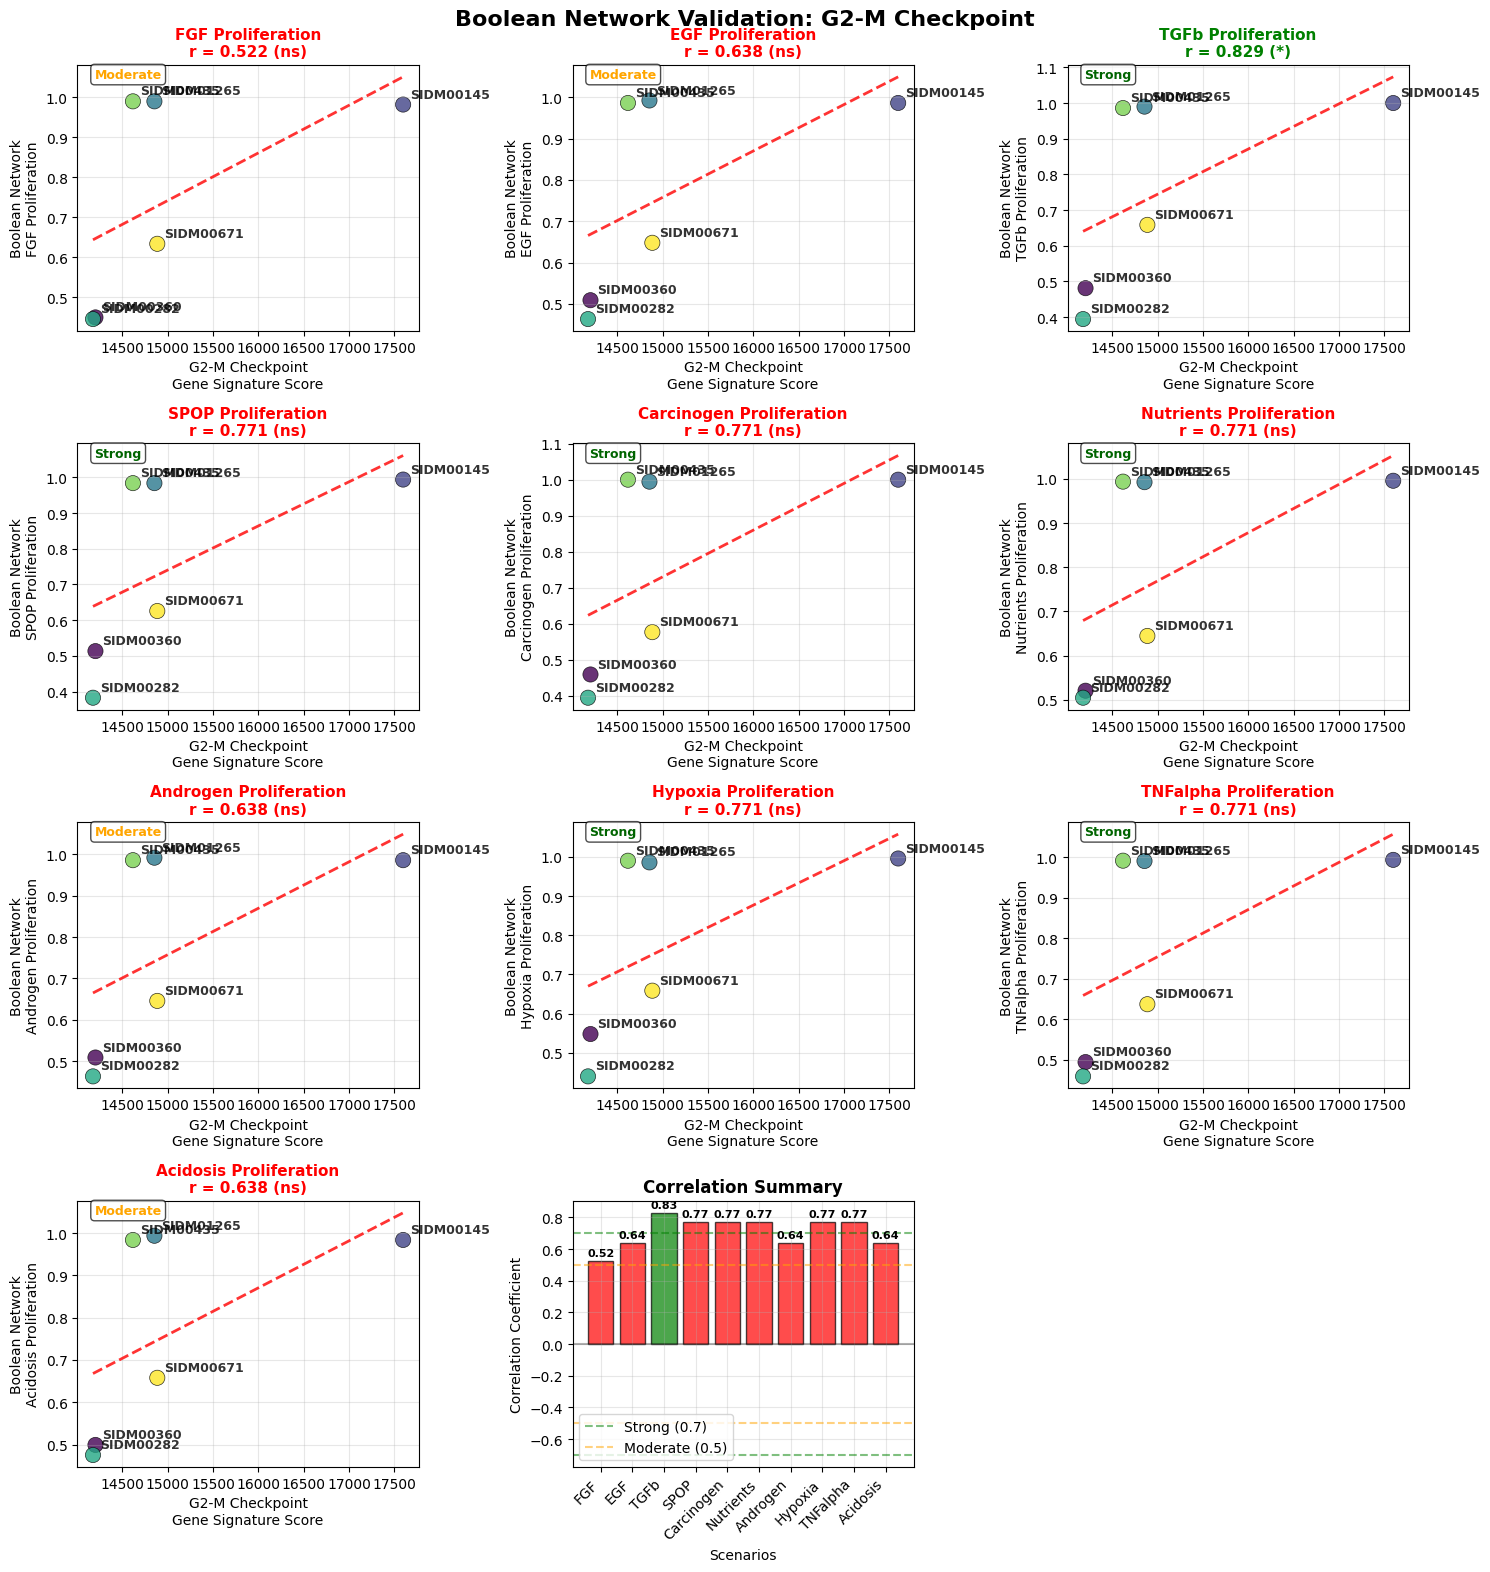

In [ ]:
# vizualise the results 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

def visualize_correlation_results(results_corr_df, correlation_data, hallmark):
    """
    Create comprehensive visualization of Boolean network validation results
    """
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Get gene signature column name
    gene_signature_col = f'{hallmark}_gene_signature_score'
    gene_scores = correlation_data[gene_signature_col]
    
    # Get Boolean network columns (excluding patient_id and gene signature)
    boolean_cols = [col for col in correlation_data.columns 
                   if col not in ['patient_id', gene_signature_col]]
    
    # Calculate number of subplots
    n_scenarios = len(boolean_cols)
    n_cols = min(3, n_scenarios)
    n_rows = max(2, (n_scenarios + n_cols - 1) // n_cols)
    
    fig = plt.figure(figsize=(5*n_cols, 4*n_rows))
    
    # Main title
    fig.suptitle(f'Boolean Network Validation: {hallmark}', fontsize=16, fontweight='bold')
    
    # Individual scatter plots
    for i, col in enumerate(boolean_cols):
        ax = plt.subplot(n_rows, n_cols, i+1)
        
        # Get data for this scenario
        boolean_probs = correlation_data[col]
        
        # Get correlation from results
        corr = float(results_corr_df.loc[col, 'correlation_value'])
        pval = float(results_corr_df.loc[col, 'p_val'])
        
        # Create scatter plot with patient labels
        scatter = ax.scatter(gene_scores, boolean_probs, 
                           alpha=0.8, s=120, 
                           c=range(len(gene_scores)), 
                           cmap='viridis',
                           edgecolors='black', linewidth=0.5)
        
        # Add patient labels
        for j, patient_id in enumerate(correlation_data['patient_id']):
            ax.annotate(patient_id, 
                       (gene_scores.iloc[j], boolean_probs.iloc[j]),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=9, alpha=0.8, fontweight='bold')
        
        # Add correlation line
        if len(gene_scores) > 1:  # Only if we have multiple points
            z = np.polyfit(gene_scores, boolean_probs, 1)
            p = np.poly1d(z)
            x_line = np.linspace(gene_scores.min(), gene_scores.max(), 100)
            ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
        
        # Formatting
        ax.set_xlabel(f'{hallmark}\nGene Signature Score', fontsize=10)
        ax.set_ylabel(f'Boolean Network\n{col.replace("_", " ")}', fontsize=10)
        
        # Title with correlation info
        if pval < 0.001:
            sig_text = "***"
        elif pval < 0.01:
            sig_text = "**"
        elif pval < 0.05:
            sig_text = "*"
        else:
            sig_text = "ns"
        
        title_text = f'{col.replace("_", " ")}\nr = {corr:.3f} ({sig_text})'
        ax.set_title(title_text, fontsize=11, fontweight='bold')
        
        # Color code the title based on significance
        if pval < 0.05:
            ax.title.set_color('green')
        else:
            ax.title.set_color('red')
        
        ax.grid(True, alpha=0.3)
        
        # Add correlation strength text
        abs_corr = abs(corr)
        if abs_corr >= 0.7:
            strength = "Strong"
            strength_color = 'darkgreen'
        elif abs_corr >= 0.5:
            strength = "Moderate"
            strength_color = 'orange'
        elif abs_corr >= 0.3:
            strength = "Weak"
            strength_color = 'red'
        else:
            strength = "Very Weak"
            strength_color = 'darkred'
        
        ax.text(0.05, 0.95, f'{strength}', transform=ax.transAxes,
                fontsize=9, fontweight='bold', color=strength_color,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
    
    # Summary statistics subplot (if space allows)
    if n_scenarios < n_rows * n_cols:
        ax_summary = plt.subplot(n_rows, n_cols, n_scenarios + 1)
        
        # Create summary statistics
        correlations = results_corr_df['correlation_value'].astype(float)
        p_values = results_corr_df['p_val'].astype(float)
        
        # Bar plot of correlations
        scenario_names = [name.split('_')[0] for name in results_corr_df.index]
        bars = ax_summary.bar(range(len(correlations)), correlations, 
                             color=['green' if p < 0.05 else 'red' for p in p_values],
                             alpha=0.7, edgecolor='black')
        
        ax_summary.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax_summary.axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Strong (0.7)')
        ax_summary.axhline(y=-0.7, color='green', linestyle='--', alpha=0.5)
        ax_summary.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Moderate (0.5)')
        ax_summary.axhline(y=-0.5, color='orange', linestyle='--', alpha=0.5)
        
        ax_summary.set_xlabel('Scenarios')
        ax_summary.set_ylabel('Correlation Coefficient')
        ax_summary.set_title('Correlation Summary', fontweight='bold')
        ax_summary.set_xticks(range(len(correlations)))
        ax_summary.set_xticklabels(scenario_names, rotation=45, ha='right')
        ax_summary.legend()
        ax_summary.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, (bar, corr, pval) in enumerate(zip(bars, correlations, p_values)):
            height = bar.get_height()
            ax_summary.text(bar.get_x() + bar.get_width()/2., height + 0.02*np.sign(height),
                           f'{corr:.2f}', ha='center', va='bottom' if height > 0 else 'top',
                           fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Use the visualization function
fig = visualize_correlation_results(results_corr_df, correlation_data, hallmark)

